In [1]:
import numpy as np
import matplotlib as plt
import os
import pickle
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Percentage error across parameter space

First off let's compute the (percentage) error for our current shifted_f() and shifted_e() equations across different parts of parameter space.

In [27]:
# Calculate percentage error of a single set of parameters
def perc_error(params, shift_regen=False, test_plot=False):

    # Unpack param dictionary
    f_low = params['f_low']
    e = params['e']
    M = params['M']
    q = params['q']
    chi1 = params['chi1']
    chi2 = params['chi2']
    phase = params['phase']
    inclination = params['inclination']

    # Create original waveform and find envelope peaks
    orig_wf = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2, phase=phase, inclination=inclination)
    orig_peaks = orig_wf.sample_times[1:-1][np.diff(np.sign(np.diff(np.abs(orig_wf))))<0]

    # Calculate shifts
    s_f = shifted_f(f_low, e, M, q)
    s_e = shifted_e(s_f, f_low, e)

    # Create shifted waveform and find envelope peaks
    s_wf = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2, phase=phase, inclination=inclination)
    s_peaks = s_wf.sample_times[1:-1][np.diff(np.sign(np.diff(np.abs(s_wf))))<0]

    # Calculate percentage error
    perr = 100*(orig_peaks[0] - s_peaks[1])/(orig_peaks[1] - orig_peaks[0])

    # Regenerate shifted waveform using calculated percentage error to improve accuracy
    if shift_regen:
        s_factor = 1/(1+perr/100)
        s_f = f_low - (f_low - s_f)*s_factor
        s_e = shifted_e(s_f, f_low, e)
        s_wf = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2, phase=phase, inclination=inclination)
        s_peaks = s_wf.sample_times[1:-1][np.diff(np.sign(np.diff(np.abs(s_wf))))<0]
        perr = 100*(orig_peaks[0] - s_peaks[1])/(orig_peaks[1] - orig_peaks[0])    

    # Test plot
    if test_plot:
        plt.plot(orig_wf.sample_times, orig_wf, c='C0', ls='dashed', alpha=0.7)
        plt.plot(orig_wf.sample_times, np.abs(orig_wf), c='C0', label='orig wf')
        plt.plot(orig_wf.sample_times, -np.abs(orig_wf), c='C0')
        plt.axvline(orig_peaks[0], c='k', label='orig peak')
        plt.plot(s_wf.sample_times, s_wf, c='C1', ls='dashed', alpha=0.7)
        plt.plot(s_wf.sample_times, np.abs(s_wf), c='C1', label='shifted_wf')
        plt.plot(s_wf.sample_times, -np.abs(s_wf), c='C1')
        plt.axvline(s_peaks[1], c='r', label='shifted peak')
        xlims = (1.25*orig_peaks[0] - 0.25*orig_peaks[1], 0.75*orig_peaks[0] + 0.25*orig_peaks[1])
        plt.xlim(xlims)
        plt.legend()

    return perr

# Calculate percentage errors varying a single parameter
def perc_errors(params, vary_key, vary_param, shift_regen=False):
    perrs = []
    for i, vp in enumerate(vary_param):
        vary_dict = params.copy()
        vary_dict[vary_key] = vp
        perrs.append(perc_error(vary_dict, shift_regen=shift_regen))
        print(f'\r{i+1} done out of {len(vary_param)}.', end='')
    return perrs

# Make plot of percentage errors varying a single parameter
def perc_errors_plot(params, vary_key, vary_param, shift_regen=False):

    # Calculate errors
    perrs = perc_errors(params, vary_key, vary_param, shift_regen=shift_regen)

    # Make plot
    plt.plot(vary_param, perrs)
    plt.axhline(0, c='k', ls='dashed', alpha=0.5, zorder=0)
    plt.xlabel(vary_key)
    plt.ylabel('% error')
    plt.xlim(np.min(vary_param), np.max(vary_param))
    plt.show()

-0.21%


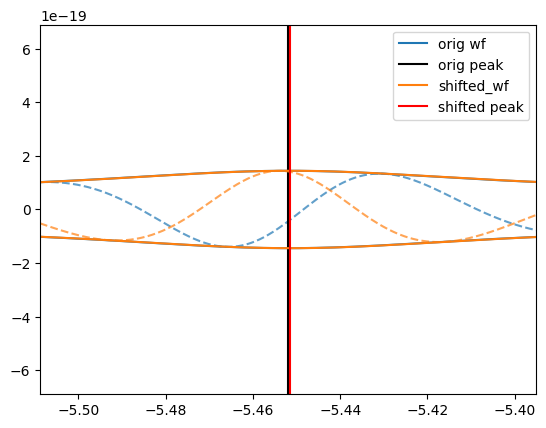

In [29]:
# Test percentage error function
param_dict = {'f_low': 10, 'e': 0.2, 'M': 60, 'q': 2, 'chi1': 0, 'chi2': 0, 'phase': 0, 'inclination': 0}
print(f'{perc_error(param_dict, test_plot=True):.2f}%')

11 done out of 11.

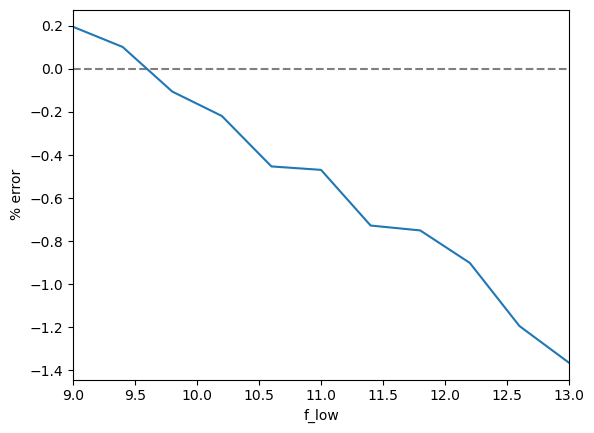

12 done out of 12.

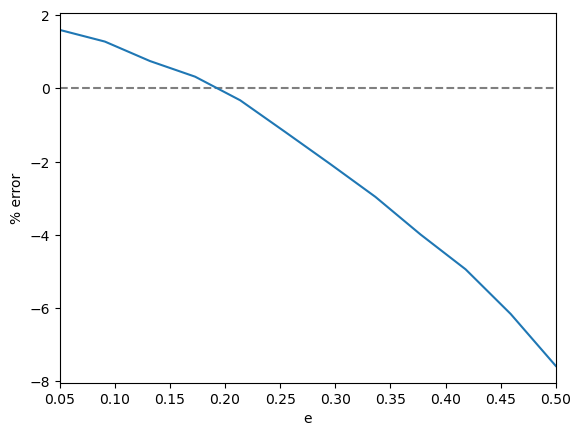

11 done out of 11.

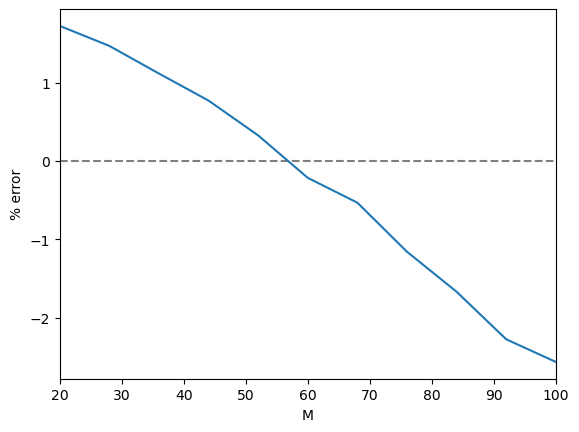

11 done out of 11.

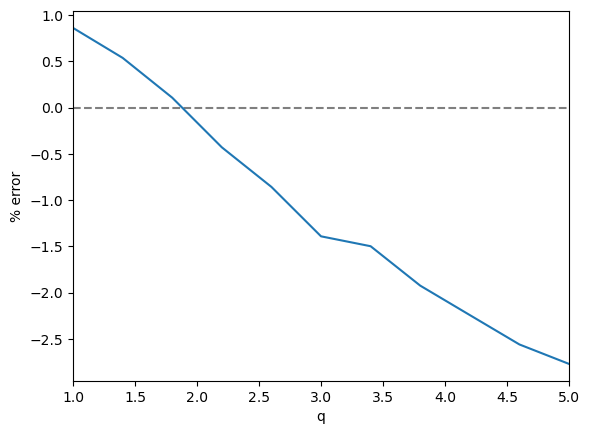

10 done out of 10.

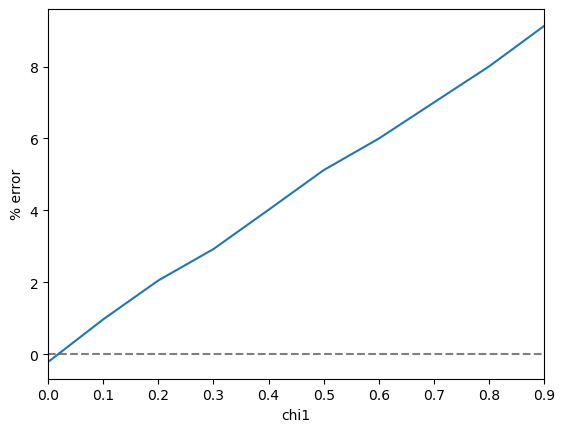

In [104]:
# Make plots over parameter space
param_dict = {'f_low': 10, 'e': 0.2, 'M': 60, 'q': 2, 'chi1': 0, 'chi2': 0, 'phase': 0, 'inclination': 0}
perc_errors_plot(param_dict, 'f_low', np.linspace(9, 13, 11))
perc_errors_plot(param_dict, 'e', np.linspace(0.05, 0.5, 12))
perc_errors_plot(param_dict, 'M', np.linspace(20, 100, 11))
perc_errors_plot(param_dict, 'q', np.linspace(1, 5, 11))
perc_errors_plot(param_dict, 'chi1', np.linspace(0, 0.9, 10))

# Reducing error numerically

Now let's try to reduce this error. We can use the percentage error we find to regenerate the shifted waveform with a new shifted frequency/eccentricity which should line up. I have added the keyword 'shift_regen' to the above functions to do this, and let's look at the error now.

0.00%


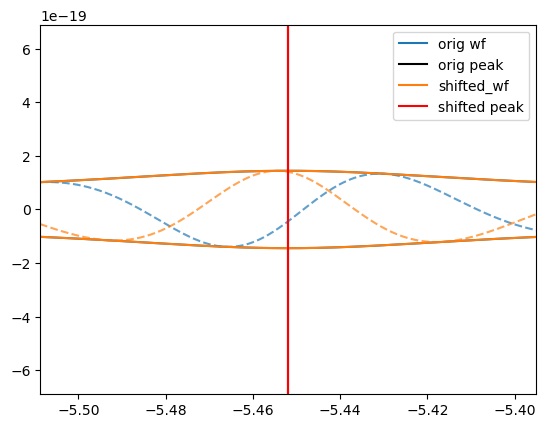

In [115]:
# Test percentage error function
param_dict = {'f_low': 10, 'e': 0.2, 'M': 60, 'q': 2, 'chi1': 0, 'chi2': 0, 'phase': 0, 'inclination': 0}
print(f'{perc_error(param_dict, shift_regen=True, test_plot=True):.2f}%')

11 done out of 11.

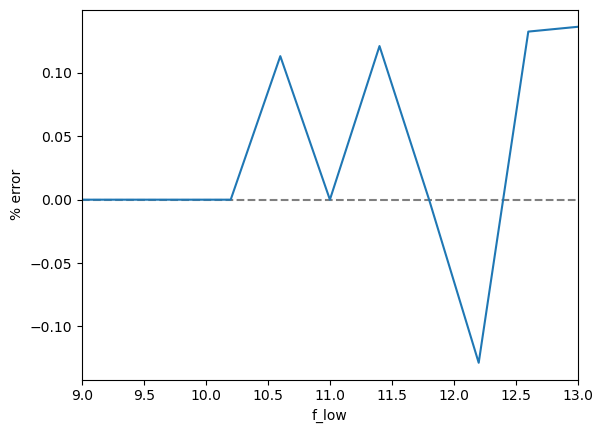

12 done out of 12.

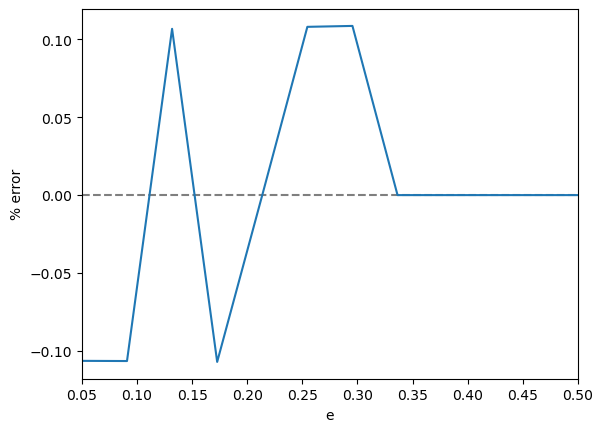

11 done out of 11.

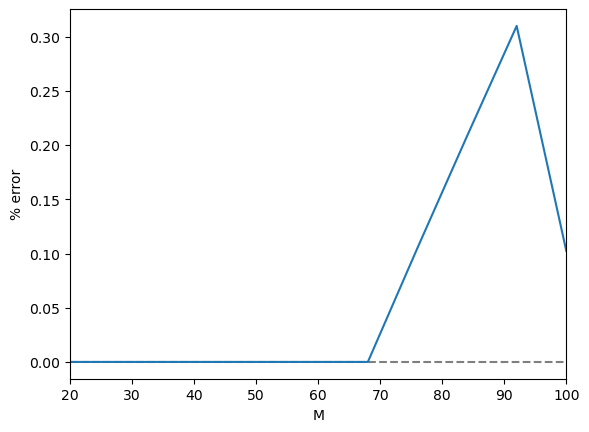

11 done out of 11.

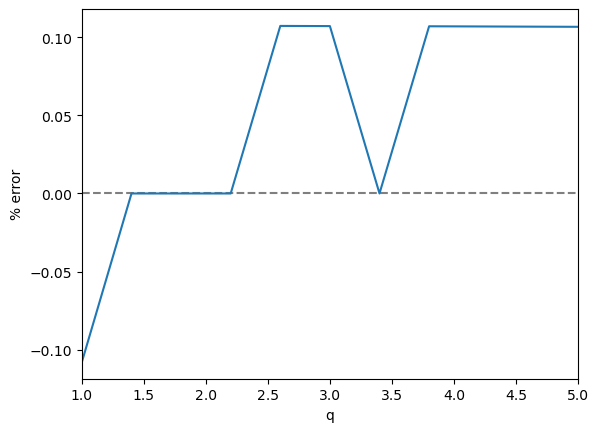

10 done out of 10.

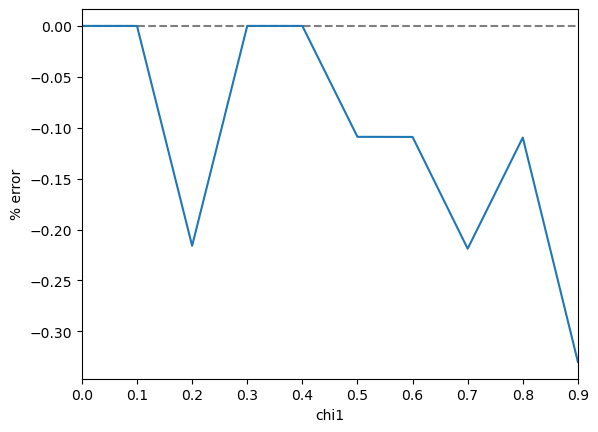

In [103]:
# Make plots over parameter space
param_dict = {'f_low': 10, 'e': 0.2, 'M': 60, 'q': 2, 'chi1': 0, 'chi2': 0, 'phase': 0, 'inclination': 0}
perc_errors_plot(param_dict, 'f_low', np.linspace(9, 13, 11), shift_regen=True)
perc_errors_plot(param_dict, 'e', np.linspace(0.05, 0.5, 12), shift_regen=True)
perc_errors_plot(param_dict, 'M', np.linspace(20, 100, 11), shift_regen=True)
perc_errors_plot(param_dict, 'q', np.linspace(1, 5, 11), shift_regen=True)
perc_errors_plot(param_dict, 'chi1', np.linspace(0, 0.9, 10), shift_regen=True)

This seems to work very well. The discrete values the percentage error takes are likely simply due to the sample rate.

# Testing improvement

This approach is now implemented in calcwf.py, so let's generate the component waveforms and check they look sensible.

(0.0, 3e-19)

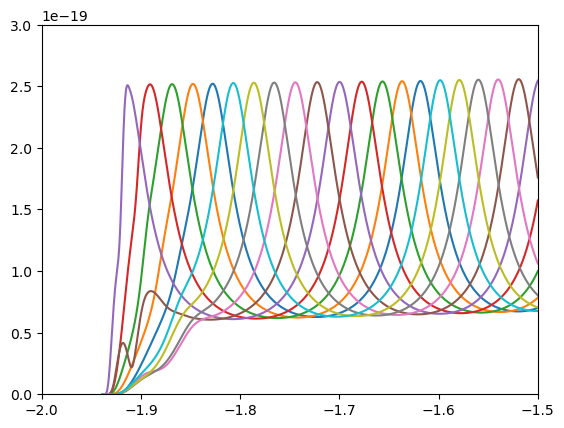

In [14]:
all_wfs = get_h([1]*10, 10, 0.5, 60, 2, 4096)
s_wfs = all_wfs[int(len(all_wfs)/2)+1:]
for s in s_wfs:
    plt.plot(s.sample_times, np.abs(s))
plt.xlim(-2,-1.5)
plt.ylim(0, 3e-19)

These now look visually equally spaced, which they did not before.

Let's also check the harmonics visually.

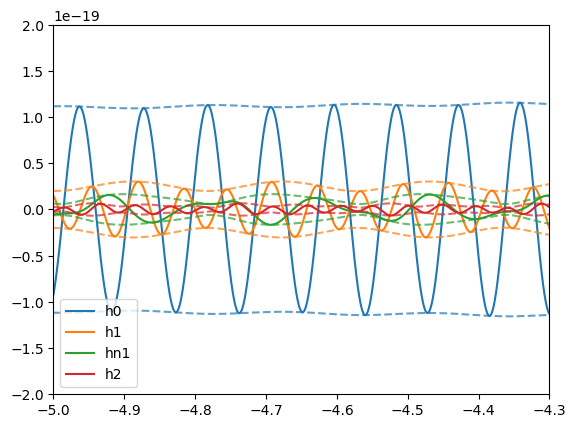

In [15]:
all_wfs = list(get_h([1]*15, 10, 0.1, 60, 2, 4096))
h0, h1, hn1, h2 = all_wfs[1:5]
plt.plot(h0.sample_times, h0, c='C0', label='h0')
plt.plot(h0.sample_times, np.abs(h0), c='C0', ls='dashed', alpha=0.7)
plt.plot(h0.sample_times, -np.abs(h0), c='C0', ls='dashed', alpha=0.7)
plt.plot(h1.sample_times, h1, c='C1', label='h1')
plt.plot(h1.sample_times, np.abs(h1), c='C1', ls='dashed', alpha=0.7)
plt.plot(h1.sample_times, -np.abs(h1), c='C1', ls='dashed', alpha=0.7)
plt.plot(hn1.sample_times, hn1, c='C2', label='hn1')
plt.plot(hn1.sample_times, np.abs(hn1), c='C2', ls='dashed', alpha=0.7)
plt.plot(hn1.sample_times, -np.abs(hn1), c='C2', ls='dashed', alpha=0.7)
plt.plot(h2.sample_times, h2, c='C3', label='h2')
plt.plot(h2.sample_times, np.abs(h2), c='C3', ls='dashed', alpha=0.7)
plt.plot(h2.sample_times, -np.abs(h2), c='C3', ls='dashed', alpha=0.7)
plt.xlim(-5,-4.3)
plt.ylim(-2e-19, 2e-19)
plt.legend()

Harmonics still look good at these low eccentricities. At higher values they look weird again however this was still the case before, so this has not worsened at least.

Let's compare matches between identical harmonics with and without this correction to the shifting we have introduced.

In [17]:
all_wfs = list(get_h([1]*15, 10, 0.4, 60, 2, 4096))
new_h0, new_h1, new_hn1, new_h2 = all_wfs[1:5]
all_wfs = list(get_h([1]*15, 10, 0.4, 60, 2, 4096, regen_shift=False))
old_h0, old_h1, old_hn1, old_h2 = all_wfs[1:5]

h0_ovlp = overlap_cplx_wfs(old_h0, new_h0, 10)
print(f'Match of h0 is {np.abs(h0_ovlp)} at {np.angle(h0_ovlp)} radians')
h1_ovlp = overlap_cplx_wfs(old_h1, new_h1, 10)
print(f'Match of h1 is {np.abs(h1_ovlp)} at {np.angle(h1_ovlp)} radians')
hn1_ovlp = overlap_cplx_wfs(old_hn1, new_hn1, 10)
print(f'Match of hn1 is {np.abs(hn1_ovlp)} at {np.angle(hn1_ovlp)} radians')
h2_ovlp = overlap_cplx_wfs(old_h2, new_h2, 10)
print(f'Match of h2 is {np.abs(h2_ovlp)} at {np.angle(h2_ovlp)} radians')

Match of h0 is 0.9990268132588211 at 0.0057978232296710015 radians
Match of h1 is 0.9971968727185665 at 0.1254196569704525 radians
Match of hn1 is 0.9962811544255604 at -0.12006221962934262 radians
Match of h2 is 0.9912568176146163 at 0.280582963957967 radians


The harmonics appear to be fairly similar still, with the difference getting larger for larger eccentricities as we would expect as the correction we made is larger here.

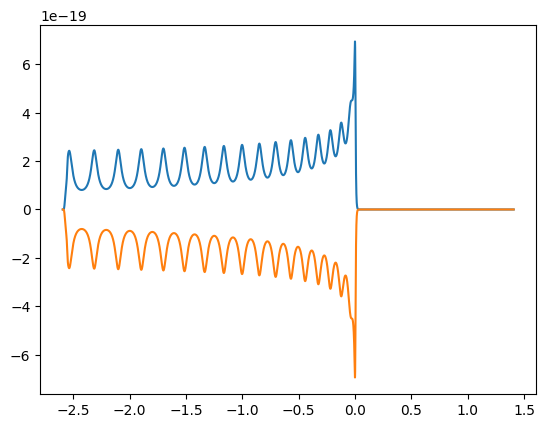

In [13]:
ex_wf = list(get_h([1]*4, 10, 0.4, chirp2total(27,2), 2, 4096))[6]
plt.plot(ex_wf.sample_times, np.abs(ex_wf))
plt.plot(ex_wf.sample_times, -np.abs(ex_wf))

# Harmonic overlaps with regen_shift=True

Let's look at harmonic overlap plots rerun with this change:

## $\mathcal{M} = 24 M_\odot$

In [40]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_7', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = list(data.keys())[1]
fid_e = list(data[fid_chirp].keys())[1]

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


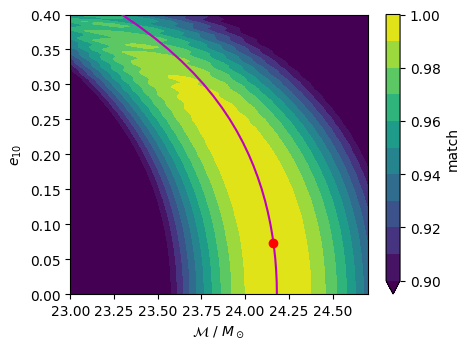

In [41]:
key = 'h0'

# Plot grid
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.9, 1, 11), vmax=1, vmin=0.9, extend='min')
plt.colorbar(label='match')
plt.scatter(fid_chirp, fid_e, c='r', zorder=5)
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()

# Plot degeneracy lines
plt.plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

# Plot formatting
plt.ylim(ylims[0], 0.4)
plt.xlim(23, xlims[1])
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e_{10}$')

plt.tight_layout()

/local/ben.patterson@ligo.org/ipykernel_2327459/1203247716.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


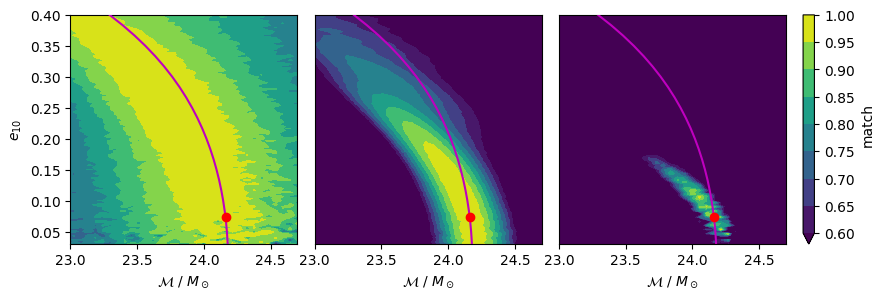

In [42]:
# Plot each grid
keys = ['h-1', 'h1', 'h2']
fig, axs = plt.subplots(ncols=4,figsize=(1.5*6.4, 0.62*4.8), gridspec_kw={'width_ratios':[1,1,1,0.05], 'wspace': 0.1})
for i in range(3):
    key = keys[i]

    # Plot grid
    contours = axs[i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.6, 1, 9), vmax=1, vmin=0.6, extend='min')
    axs[i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[i].get_xlim()

    # Plot degeneracy lines
    axs[i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

    # Plot formatting
    axs[i].set_ylim(0.03, 0.4)
    axs[i].set_xlim(23, xlims[1])
    axs[i].set_xlabel('$\mathcal{M}~/~M_\odot$')
    axs[i].set_ylabel('$e_{10}$')
    if i > 0:
        axs[i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[-1], label='match')
plt.tight_layout()

## $\mathcal{M} = 10 M_\odot$

In [37]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_7', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = list(data.keys())[0]
fid_e = list(data[fid_chirp].keys())[0]

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


/local/ben.patterson@ligo.org/ipykernel_2327459/2175234641.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


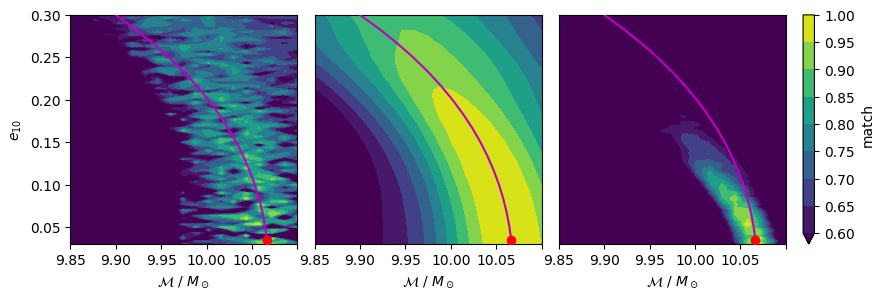

In [39]:
# Plot each grid
keys = ['h-1', 'h0', 'h1']
fig, axs = plt.subplots(ncols=4,figsize=(1.5*6.4, 0.62*4.8), gridspec_kw={'width_ratios':[1,1,1,0.05], 'wspace': 0.1})
for i in range(3):
    key = keys[i]

    # Plot grid
    contours = axs[i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.6, 1, 9), vmax=1, vmin=0.6, extend='min')
    axs[i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[i].get_xlim()

    # Plot degeneracy lines
    axs[i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

    # Plot formatting
    axs[i].set_ylim(0.03, 0.3)
    axs[i].set_xlim(9.85, 10.1)
    axs[i].set_xlabel('$\mathcal{M}~/~M_\odot$')
    axs[i].set_ylabel('$e_{10}$')
    axs[i].set_xticks(axs[i].get_xticks(), labels=axs[i].get_xticklabels()[:-1]+[''])
    if i > 0:
        axs[i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[-1], label='match')
plt.tight_layout()

## $\mathcal{M} = 40 M_\odot$

In [43]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_7', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = list(data.keys())[2]
fid_e = list(data[fid_chirp].keys())[2]

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


/local/ben.patterson@ligo.org/ipykernel_2327459/4259392039.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


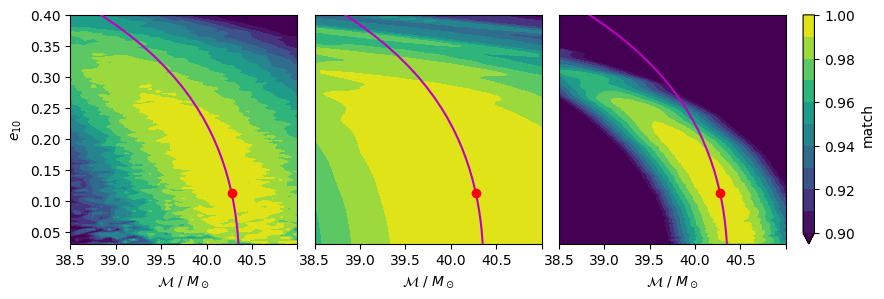

In [44]:
# Plot each grid
keys = ['h-1', 'h0', 'h1']
fig, axs = plt.subplots(ncols=4,figsize=(1.5*6.4, 0.62*4.8), gridspec_kw={'width_ratios':[1,1,1,0.05], 'wspace': 0.1})
for i in range(3):
    key = keys[i]

    # Plot grid
    contours = axs[i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.9, 1, 11), vmax=1, vmin=0.9, extend='min')
    axs[i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[i].get_xlim()

    # Plot degeneracy lines
    axs[i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

    # Plot formatting
    axs[i].set_ylim(0.03, 0.4)
    axs[i].set_xlim(38.5, 41)
    axs[i].set_xlabel('$\mathcal{M}~/~M_\odot$')
    axs[i].set_ylabel('$e_{10}$')
    axs[i].set_xticks(axs[i].get_xticks(), labels=axs[i].get_xticklabels()[:-1]+[''])
    if i > 0:
        axs[i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[-1], label='match')
plt.tight_layout()

# Harmonic overlaps with regen_shift=False

## $\mathcal{M} = 24 M_\odot$

In [2]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_8', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = list(data.keys())[1]
fid_e = list(data[fid_chirp].keys())[1]

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/t

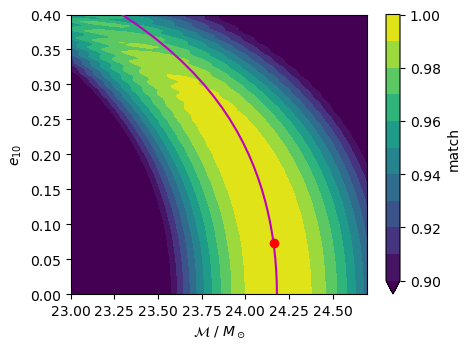

In [3]:
key = 'h0'

# Plot grid
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.9, 1, 11), vmax=1, vmin=0.9, extend='min')
plt.colorbar(label='match')
plt.scatter(fid_chirp, fid_e, c='r', zorder=5)
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()

# Plot degeneracy lines
plt.plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

# Plot formatting
plt.ylim(ylims[0], 0.4)
plt.xlim(23, xlims[1])
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e_{10}$')

plt.tight_layout()

/tmp/ipykernel_2630780/1203247716.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


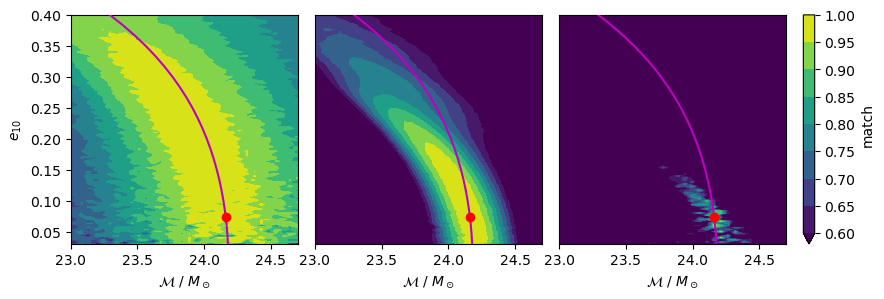

In [4]:
# Plot each grid
keys = ['h-1', 'h1', 'h2']
fig, axs = plt.subplots(ncols=4,figsize=(1.5*6.4, 0.62*4.8), gridspec_kw={'width_ratios':[1,1,1,0.05], 'wspace': 0.1})
for i in range(3):
    key = keys[i]

    # Plot grid
    contours = axs[i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.6, 1, 9), vmax=1, vmin=0.6, extend='min')
    axs[i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[i].get_xlim()

    # Plot degeneracy lines
    axs[i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

    # Plot formatting
    axs[i].set_ylim(0.03, 0.4)
    axs[i].set_xlim(23, xlims[1])
    axs[i].set_xlabel('$\mathcal{M}~/~M_\odot$')
    axs[i].set_ylabel('$e_{10}$')
    if i > 0:
        axs[i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[-1], label='match')
plt.tight_layout()

## $\mathcal{M} = 10 M_\odot$

In [7]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_8', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = list(data.keys())[0]
fid_e = list(data[fid_chirp].keys())[0]

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


/tmp/ipykernel_2630780/2175234641.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


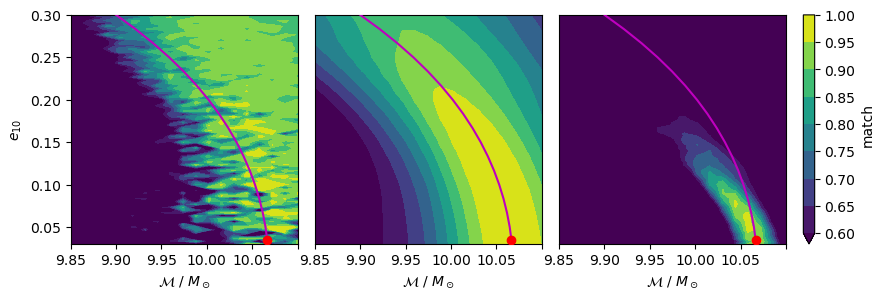

In [8]:
# Plot each grid
keys = ['h-1', 'h0', 'h1']
fig, axs = plt.subplots(ncols=4,figsize=(1.5*6.4, 0.62*4.8), gridspec_kw={'width_ratios':[1,1,1,0.05], 'wspace': 0.1})
for i in range(3):
    key = keys[i]

    # Plot grid
    contours = axs[i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.6, 1, 9), vmax=1, vmin=0.6, extend='min')
    axs[i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[i].get_xlim()

    # Plot degeneracy lines
    axs[i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

    # Plot formatting
    axs[i].set_ylim(0.03, 0.3)
    axs[i].set_xlim(9.85, 10.1)
    axs[i].set_xlabel('$\mathcal{M}~/~M_\odot$')
    axs[i].set_ylabel('$e_{10}$')
    axs[i].set_xticks(axs[i].get_xticks(), labels=axs[i].get_xticklabels()[:-1]+[''])
    if i > 0:
        axs[i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[-1], label='match')
plt.tight_layout()

## $\mathcal{M} = 40 M_\odot$

In [9]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_8', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = list(data.keys())[2]
fid_e = list(data[fid_chirp].keys())[2]

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


/tmp/ipykernel_2630780/4259392039.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


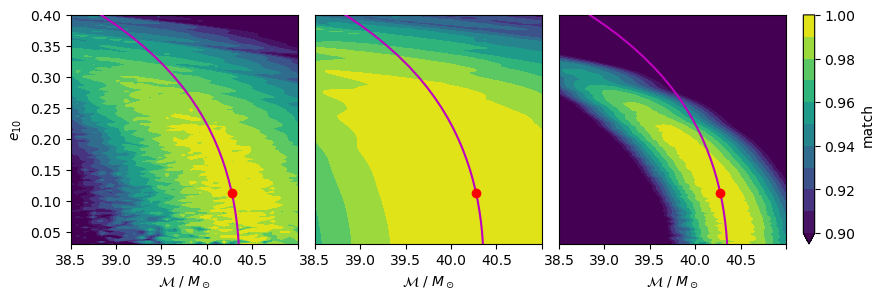

In [10]:
# Plot each grid
keys = ['h-1', 'h0', 'h1']
fig, axs = plt.subplots(ncols=4,figsize=(1.5*6.4, 0.62*4.8), gridspec_kw={'width_ratios':[1,1,1,0.05], 'wspace': 0.1})
for i in range(3):
    key = keys[i]

    # Plot grid
    contours = axs[i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.9, 1, 11), vmax=1, vmin=0.9, extend='min')
    axs[i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[i].get_xlim()

    # Plot degeneracy lines
    axs[i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

    # Plot formatting
    axs[i].set_ylim(0.03, 0.4)
    axs[i].set_xlim(38.5, 41)
    axs[i].set_xlabel('$\mathcal{M}~/~M_\odot$')
    axs[i].set_ylabel('$e_{10}$')
    axs[i].set_xticks(axs[i].get_xticks(), labels=axs[i].get_xticklabels()[:-1]+[''])
    if i > 0:
        axs[i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[-1], label='match')
plt.tight_layout()